In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.5.1
CUDA Available: True
Using device: cuda


## Data Loading

In [2]:
import torch
import pandas as pd
import numpy as np
import os

# --- Configuration ---
DATA_DIR = 'data/'
X_TRAIN_PATH = os.path.join(DATA_DIR, 'x_train.csv')
Y_TRAIN_PATH = os.path.join(DATA_DIR, 'y_train.csv')
X_TEST_PATH = os.path.join(DATA_DIR, 'x_test.csv')
Y_TEST_PATH = os.path.join(DATA_DIR, 'y_test.csv')

EXPECTED_TRAIN_SAMPLES = 60000
EXPECTED_TEST_SAMPLES = 10000
EXPECTED_FEATURES = 784
EXPECTED_IMG_SHAPE_TENSOR = (1, 28, 28) # (C, H, W)
EXPECTED_LABEL_CLASSES = 5

print("--- 1. Loading Data ---")
try:
    x_train_df = pd.read_csv(X_TRAIN_PATH)
    y_train_df = pd.read_csv(Y_TRAIN_PATH)
    x_test_df = pd.read_csv(X_TEST_PATH)
    y_test_df = pd.read_csv(Y_TEST_PATH)
    print("CSV files loaded into Pandas DataFrames successfully.")
except Exception as e:
    print(f"Error loading CSV files: {e}")
    raise

print("\n--- 2. Inspecting DataFrames (Raw) ---")
print(f"x_train_df shape: {x_train_df.shape}")
print(f"y_train_df shape: {y_train_df.shape}")
print(f"x_test_df shape: {x_test_df.shape}")
print(f"y_test_df shape: {y_test_df.shape}")


print("\nx_train_df Head:")
print(x_train_df.head(3))
print("\ny_train_df Head:")
print(y_train_df.head(3))

label_col_name = y_train_df.columns[0]
print(f"\nValue Counts for column '{label_col_name}' in y_train_df:")
print(y_train_df[label_col_name].value_counts().sort_index())

# Check for NaN values
print(f"\nNaN values check:")
print(f"  x_train: {x_train_df.isnull().sum().sum()}")
print(f"  y_train: {y_train_df.isnull().sum().sum()}")
print(f"  x_test: {x_test_df.isnull().sum().sum()}")
print(f"  y_test: {y_test_df.isnull().sum().sum()}")

# Verify shapes match expectations (rows)
assert x_train_df.shape[0] == EXPECTED_TRAIN_SAMPLES, f"Unexpected number of rows in x_train_df"
assert y_train_df.shape[0] == EXPECTED_TRAIN_SAMPLES, f"Unexpected number of rows in y_train_df"
assert x_test_df.shape[0] == EXPECTED_TEST_SAMPLES, f"Unexpected number of rows in x_test_df"
assert y_test_df.shape[0] == EXPECTED_TEST_SAMPLES, f"Unexpected number of rows in y_test_df"
# Verify features/columns
assert x_train_df.shape[1] == EXPECTED_FEATURES, f"Unexpected number of columns in x_train_df"
assert x_test_df.shape[1] == EXPECTED_FEATURES, f"Unexpected number of columns in x_test_df"
assert y_train_df.shape[1] == 1, f"Unexpected number of columns in y_train_df"
assert y_test_df.shape[1] == 1, f"Unexpected number of columns in y_test_df"

print("\nDataFrame shapes and basic content look correct.")

print("\n--- 3. Converting, Reshaping, Normalizing ---")
x_train_np = x_train_df.values
y_train_np = y_train_df.values.squeeze()
x_test_np = x_test_df.values
y_test_np = y_test_df.values.squeeze()

x_train_tensor = torch.from_numpy(x_train_np).float()
y_train_tensor = torch.from_numpy(y_train_np).long()
x_test_tensor = torch.from_numpy(x_test_np).float()
y_test_tensor = torch.from_numpy(y_test_np).long()

# Reshape image data for CNNs
# (N, C, H, W)
x_train_tensor = x_train_tensor.reshape(-1, *EXPECTED_IMG_SHAPE_TENSOR) # (N, 1, 28, 28)
x_test_tensor = x_test_tensor.reshape(-1, *EXPECTED_IMG_SHAPE_TENSOR)  # (N, 1, 28, 28)

# Normalize pixel values
# Scale pixel values from [0, 255] to [0, 1]
x_train_tensor = x_train_tensor / 255.0
x_test_tensor = x_test_tensor / 255.0

print("Data converted to Tensors, reshaped, and normalized.")

print("\n--- 4. Verifying Processed Tensors ---")
assert x_train_tensor.shape == (EXPECTED_TRAIN_SAMPLES, *EXPECTED_IMG_SHAPE_TENSOR), \
    f"x_train_tensor shape mismatch: Expected {(EXPECTED_TRAIN_SAMPLES, *EXPECTED_IMG_SHAPE_TENSOR)}, Got {x_train_tensor.shape}"
assert y_train_tensor.shape == (EXPECTED_TRAIN_SAMPLES,), \
    f"y_train_tensor shape mismatch: Expected {(EXPECTED_TRAIN_SAMPLES,)}, Got {y_train_tensor.shape}"
assert x_test_tensor.shape == (EXPECTED_TEST_SAMPLES, *EXPECTED_IMG_SHAPE_TENSOR), \
    f"x_test_tensor shape mismatch: Expected {(EXPECTED_TEST_SAMPLES, *EXPECTED_IMG_SHAPE_TENSOR)}, Got {x_test_tensor.shape}"
assert y_test_tensor.shape == (EXPECTED_TEST_SAMPLES,), \
    f"y_test_tensor shape mismatch: Expected {(EXPECTED_TEST_SAMPLES,)}, Got {y_test_tensor.shape}"
print("Tensor shapes are correct.")

print("\n--- Data Loading and Preprocessing Complete ---")

--- 1. Loading Data ---
CSV files loaded into Pandas DataFrames successfully.

--- 2. Inspecting DataFrames (Raw) ---
x_train_df shape: (60000, 784)
y_train_df shape: (60000, 1)
x_test_df shape: (10000, 784)
y_test_df shape: (10000, 1)

x_train_df Head:
   0  1  2  3  4  5  6  7  8   9  ...  774  775  776  777  778  779  780  781  \
0  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0    0    0    0   
1  0  0  0  0  0  1  0  0  0   0  ...  119  114  130   76    0    0    0    0   
2  0  0  0  0  0  0  0  0  0  22  ...    0    0    1    0    0    0    0    0   

   782  783  
0    0    0  
1    0    0  
2    0    0  

[3 rows x 784 columns]

y_train_df Head:
   0
0  1
1  2
2  2

Value Counts for column '0' in y_train_df:
0
0     6000
1    12000
2    30000
3     6000
4     6000
Name: count, dtype: int64

NaN values check:
  x_train: 0
  y_train: 0
  x_test: 0
  y_test: 0

DataFrame shapes and basic content look correct.

--- 3. Converting, Reshaping, Normalizing ---
Data conve

Displaying random samples from the training set...


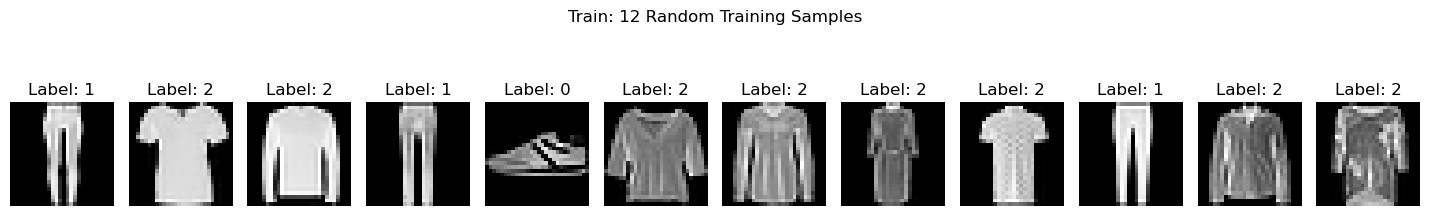

In [4]:
def show_images(dataset, labels, n_samples=10, title_prefix=""):
    """Displays n_samples random images from the dataset."""
    plt.figure(figsize=(n_samples * 1.2, 2.5)) # Adjust figure size based on number of samples
    indices = np.random.choice(len(dataset), n_samples, replace=False)
    for i, idx in enumerate(indices):
        img = dataset[idx]      # Shape (1, 28, 28)
        label = labels[idx].item() # Get scalar value from tensor

        img_display = img.squeeze().cpu().numpy()

        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img_display, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(f"{title_prefix}{n_samples} Random Training Samples", y=1.02)
    plt.tight_layout()
    plt.show()

print("Displaying random samples from the training set...")
show_images(x_train_tensor, y_train_tensor, n_samples=12, title_prefix="Train: ")

In [5]:
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

# --- Hyperparameters for Data Loading ---
VALIDATION_SPLIT = 0.2 # Use 20% of the training data for validation
BATCH_SIZE = 64        # Batch size for training and evaluation


full_train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

print(f"Created TensorDatasets:")
print(f"  Full training set size: {len(full_train_dataset)}")
print(f"  Test set size: {len(test_dataset)}")


num_train_samples = len(full_train_dataset)
num_val_samples = int(VALIDATION_SPLIT * num_train_samples)
num_train_split = num_train_samples - num_val_samples

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [num_train_split, num_val_samples],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\nSplit training data:")
print(f"  Training subset size: {len(train_dataset)}")
print(f"  Validation subset size: {len(val_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nCreated DataLoaders:")
print(f"  Train loader: {len(train_loader)} batches of size {BATCH_SIZE}")
print(f"  Validation loader: {len(val_loader)} batches of size {BATCH_SIZE}")
print(f"  Test loader: {len(test_loader)} batches of size {BATCH_SIZE}")


Created TensorDatasets:
  Full training set size: 60000
  Test set size: 10000

Split training data:
  Training subset size: 48000
  Validation subset size: 12000

Created DataLoaders:
  Train loader: 750 batches of size 64
  Validation loader: 188 batches of size 64
  Test loader: 157 batches of size 64


## Helper Functions

In [8]:
# Training and Evaluation Functions

import time

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Trains the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    start_time = time.time()
    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward Pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

    epoch_time = time.time() - start_time
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc, epoch_time


def evaluate(model, dataloader, criterion, device):
    """Evaluates the model on a given dataset."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    eval_time = time.time() - start_time
    eval_loss = running_loss / total_samples
    eval_acc = correct_predictions / total_samples

    return eval_loss, eval_acc, eval_time


## Q1 - Default Architecture

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class DefaultCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(DefaultCNN, self).__init__()
        # Layer 1: Conv -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Input: (N, 1, 28, 28)
        # Conv1 Output: (N, 32, 28, 28) (Padding keeps size same: 28 - 3 + 2*1 + 1 = 28)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool1 Output: (N, 32, 14, 14) (28 / 2 = 14)

        # Layer 2: Conv -> ReLU
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Input: (N, 32, 14, 14)
        # Conv2 Output: (N, 32, 14, 14) (Padding keeps size same: 14 - 3 + 2*1 + 1 = 14)

        # Dense Layers
        # Output of conv2 is (N, 32, 14, 14)
        self.flattened_size = 32 * 14 * 14
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        x = F.relu(x)

        x = x.view(x.size(0), -1)

        # Dense Layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

q1_model = DefaultCNN(num_classes=EXPECTED_LABEL_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_q1 = optim.SGD(q1_model.parameters(), lr=0.01, momentum=0.9)

print("--- Q1 Default CNN Architecture ---")
print(q1_model)

# try:
#     from torchsummary import summary
#     # Provide the input shape (C, H, W) excluding the batch dimension
#     summary(q1_model, input_size=EXPECTED_IMG_SHAPE_TENSOR, device=device.type)
# except ImportError:
#     print("\n'torchsummary' not found. Skipping detailed summary.")
#     print(f"Model has {sum(p.numel() for p in q1_model.parameters() if p.requires_grad):,} trainable parameters.")

--- Q1 Default CNN Architecture ---
DefaultCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)


In [12]:
# Training Hyperparameters
NUM_EPOCHS_Q1 = 15
MODEL_NAME_Q1 = "DefaultCNN_Q1"

print(f"--- Training {MODEL_NAME_Q1} for {NUM_EPOCHS_Q1} epochs ---")
print(f"Device: {device}")
print(f"Optimizer: {type(optimizer_q1).__name__} (LR={optimizer_q1.defaults['lr']})")
print(f"Batch size: {BATCH_SIZE}")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

# --- History Tracking ---
history_q1 = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_time': []
}

total_train_start_time = time.time()

for epoch in range(NUM_EPOCHS_Q1):
    train_loss, train_acc, train_time = train_one_epoch(
        q1_model, train_loader, criterion, optimizer_q1, device
    )

    val_loss, val_acc, val_time = evaluate(
        q1_model, val_loader, criterion, device
    )

    # Record history
    history_q1['train_loss'].append(train_loss)
    history_q1['train_acc'].append(train_acc)
    history_q1['val_loss'].append(val_loss)
    history_q1['val_acc'].append(val_acc)
    history_q1['epoch_time'].append(train_time + val_time)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS_Q1} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} ({train_time:.2f}s) | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ({val_time:.2f}s)")

total_train_end_time = time.time()
total_training_time_q1 = total_train_end_time - total_train_start_time
avg_epoch_time_q1 = sum(history_q1['epoch_time']) / NUM_EPOCHS_Q1

print(f"\n--- Training Finished ---")
print(f"Total Training Time ({MODEL_NAME_Q1}): {total_training_time_q1:.2f}s")
print(f"Average Epoch Time ({MODEL_NAME_Q1}): {avg_epoch_time_q1:.2f}s")

# --- Evaluate Final Model on Test Set ---
print(f"\n--- Evaluating {MODEL_NAME_Q1} on Test Set ---")
test_loss_q1, test_acc_q1, test_time_q1 = evaluate(
    q1_model, test_loader, criterion, device
)
print(f"Test Loss ({MODEL_NAME_Q1}): {test_loss_q1:.4f}")
print(f"Test Accuracy ({MODEL_NAME_Q1}): {test_acc_q1:.4f}")
print(f"Test Evaluation Time ({MODEL_NAME_Q1}): {test_time_q1:.2f}s")

# Store test results
history_q1['test_loss'] = test_loss_q1
history_q1['test_acc'] = test_acc_q1
history_q1['test_time'] = test_time_q1
history_q1['total_train_time'] = total_training_time_q1

--- Training DefaultCNN_Q1 for 15 epochs ---
Device: cuda
Optimizer: SGD (LR=0.01)
Batch size: 64
Train samples: 48000, Val samples: 12000
Epoch 1/15 | Train Loss: 0.2144, Train Acc: 0.9278 (7.92s) | Val Loss: 0.1122, Val Acc: 0.9650 (3.05s)
Epoch 2/15 | Train Loss: 0.0919, Train Acc: 0.9713 (8.08s) | Val Loss: 0.0873, Val Acc: 0.9722 (3.30s)
Epoch 3/15 | Train Loss: 0.0716, Train Acc: 0.9771 (8.05s) | Val Loss: 0.0746, Val Acc: 0.9749 (3.96s)
Epoch 4/15 | Train Loss: 0.0586, Train Acc: 0.9816 (8.99s) | Val Loss: 0.0685, Val Acc: 0.9772 (3.37s)
Epoch 5/15 | Train Loss: 0.0497, Train Acc: 0.9837 (7.90s) | Val Loss: 0.0601, Val Acc: 0.9792 (3.55s)
Epoch 6/15 | Train Loss: 0.0432, Train Acc: 0.9857 (8.27s) | Val Loss: 0.0614, Val Acc: 0.9789 (3.73s)
Epoch 7/15 | Train Loss: 0.0379, Train Acc: 0.9871 (9.54s) | Val Loss: 0.0548, Val Acc: 0.9805 (4.16s)
Epoch 8/15 | Train Loss: 0.0342, Train Acc: 0.9880 (8.82s) | Val Loss: 0.0503, Val Acc: 0.9824 (3.35s)
Epoch 9/15 | Train Loss: 0.0308, Trai

## Q2 - Improved Architecture

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super(ImprovedCNN, self).__init__()
        # Layer 1: Conv -> BN -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Input: (N, 1, 28, 28) -> Conv1: (N, 32, 28, 28) -> BN1 -> ReLU -> Pool1: (N, 32, 14, 14)

        # Layer 2: Conv -> BN -> ReLU -> MaxPool
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Batch Norm after Conv2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Input: (N, 32, 14, 14) -> Conv2: (N, 64, 14, 14) -> BN2 -> ReLU -> Pool2: (N, 64, 7, 7)

        self.flattened_size = 64 * 7 * 7

        # Dense Layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Layer 
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        # Dense Layers
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


q2_model = ImprovedCNN(num_classes=EXPECTED_LABEL_CLASSES, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_q2 = optim.Adam(q2_model.parameters(), lr=0.001) # Using Adam optimizer

print("--- Q2 Improved CNN Architecture ---")
print(q2_model)


# try:
#     from torchsummary import summary
#     summary(q2_model, input_size=EXPECTED_IMG_SHAPE_TENSOR, device=device.type)
# except ImportError:
#     print("\n'torchsummary' not found. Skipping detailed summary.")
#     print(f"Model has {sum(p.numel() for p in q2_model.parameters() if p.requires_grad):,} trainable parameters.")

--- Q2 Improved CNN Architecture ---
ImprovedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)


In [10]:
# Training Hyperparameters
NUM_EPOCHS_Q2 = 15
MODEL_NAME_Q2 = "ImprovedCNN_Q2"

print(f"--- Training {MODEL_NAME_Q2} for {NUM_EPOCHS_Q2} epochs ---")
print(f"Device: {device}")
print(f"Optimizer: {type(optimizer_q2).__name__} (LR={optimizer_q2.defaults['lr']})")
print(f"Batch size: {BATCH_SIZE}")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print(f"Dropout rate: {q2_model.dropout.p}")

# History Tracking  
history_q2 = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_time': []
}

total_train_start_time = time.time()

for epoch in range(NUM_EPOCHS_Q2):
    train_loss, train_acc, train_time = train_one_epoch(
        q2_model, train_loader, criterion, optimizer_q2, device
    )

    val_loss, val_acc, val_time = evaluate(
        q2_model, val_loader, criterion, device
    )

    # Record history
    history_q2['train_loss'].append(train_loss)
    history_q2['train_acc'].append(train_acc)
    history_q2['val_loss'].append(val_loss)
    history_q2['val_acc'].append(val_acc)
    history_q2['epoch_time'].append(train_time + val_time)


    print(f"Epoch {epoch+1}/{NUM_EPOCHS_Q2} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} ({train_time:.2f}s) | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ({val_time:.2f}s)")

total_train_end_time = time.time()
total_training_time_q2 = total_train_end_time - total_train_start_time
avg_epoch_time_q2 = sum(history_q2['epoch_time']) / NUM_EPOCHS_Q2 if NUM_EPOCHS_Q2 > 0 else 0

print(f"\n--- Training Finished ---")
print(f"Total Training Time ({MODEL_NAME_Q2}): {total_training_time_q2:.2f}s")
print(f"Average Epoch Time ({MODEL_NAME_Q2}): {avg_epoch_time_q2:.2f}s")

# Evaluate Final Model on Test Set
print(f"\n--- Evaluating {MODEL_NAME_Q2} on Test Set ---")
test_loss_q2, test_acc_q2, test_time_q2 = evaluate(
    q2_model, test_loader, criterion, device
)
print(f"Test Loss ({MODEL_NAME_Q2}): {test_loss_q2:.4f}")
print(f"Test Accuracy ({MODEL_NAME_Q2}): {test_acc_q2:.4f}")
print(f"Test Evaluation Time ({MODEL_NAME_Q2}): {test_time_q2:.2f}s")

# Store test results
history_q2['test_loss'] = test_loss_q2
history_q2['test_acc'] = test_acc_q2
history_q2['test_time'] = test_time_q2
history_q2['total_train_time'] = total_training_time_q2

--- Training ImprovedCNN_Q2 for 15 epochs ---
Device: cuda
Optimizer: Adam (LR=0.001)
Batch size: 64
Train samples: 48000, Val samples: 12000
Dropout rate: 0.5
Epoch 1/15 | Train Loss: 0.0947, Train Acc: 0.9690 (10.34s) | Val Loss: 0.0567, Val Acc: 0.9802 (3.24s)
Epoch 2/15 | Train Loss: 0.0520, Train Acc: 0.9829 (9.44s) | Val Loss: 0.0523, Val Acc: 0.9828 (3.51s)
Epoch 3/15 | Train Loss: 0.0395, Train Acc: 0.9864 (9.94s) | Val Loss: 0.0482, Val Acc: 0.9832 (3.68s)
Epoch 4/15 | Train Loss: 0.0319, Train Acc: 0.9881 (10.25s) | Val Loss: 0.0364, Val Acc: 0.9858 (4.27s)
Epoch 5/15 | Train Loss: 0.0275, Train Acc: 0.9905 (10.02s) | Val Loss: 0.0468, Val Acc: 0.9852 (3.50s)
Epoch 6/15 | Train Loss: 0.0213, Train Acc: 0.9923 (10.72s) | Val Loss: 0.0435, Val Acc: 0.9862 (3.92s)
Epoch 7/15 | Train Loss: 0.0230, Train Acc: 0.9918 (10.77s) | Val Loss: 0.0435, Val Acc: 0.9860 (3.96s)
Epoch 8/15 | Train Loss: 0.0184, Train Acc: 0.9932 (8.81s) | Val Loss: 0.0461, Val Acc: 0.9872 (3.19s)
Epoch 9/15 

## Validation Accuracy over Epochs

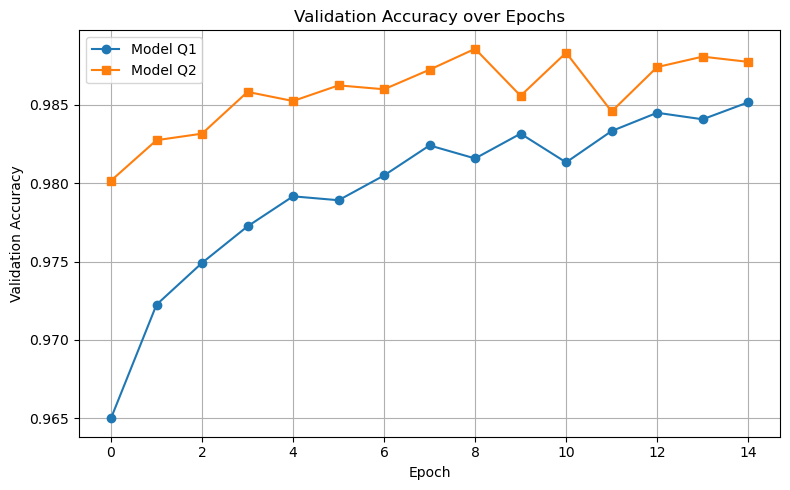

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(history_q1['val_acc'], label='Model Q1', marker='o')
plt.plot(history_q2['val_acc'], label='Model Q2', marker='s')

plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## CNN Feature Extractor (size 512 Dense Layer)

In [26]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            nn.ReLU(),
            original_model.pool1,
            original_model.conv2,
            original_model.bn2,
            nn.ReLU(),
            original_model.pool2
        )
        self.flatten = nn.Flatten()
        self.fc1 = original_model.fc1
        self.bn3 = original_model.bn3
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu(x)
        return x  # Return 512-dim encoded features

# Move model to the same device
feature_model = FeatureExtractor(q2_model).to(device)
feature_model.eval()

# Collect features
all_features = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        features = feature_model(inputs)
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

# Concatenate all features and labels
all_features_tensor = torch.cat(all_features, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)

# Convert to pandas DataFrame
features_df = pd.DataFrame(all_features_tensor.numpy())
features_df['label'] = all_labels_tensor.numpy()  # Add labels as a column

print("Feature extraction complete.")
print(features_df.shape)

Feature extraction complete.
(12000, 513)


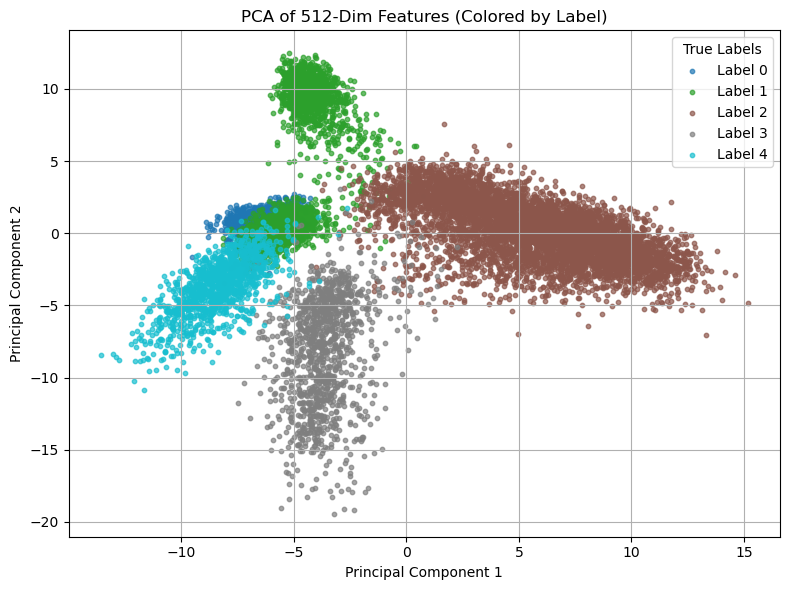

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Extract features and labels
X = features_df.drop(columns=["label"]).values
y = features_df["label"].values
unique_labels = np.unique(y)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], 
                color=colors[i], label=f"Label {label}", alpha=0.7, s=10)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of 512-Dim Features (Colored by Label)")
plt.legend(title="True Labels", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

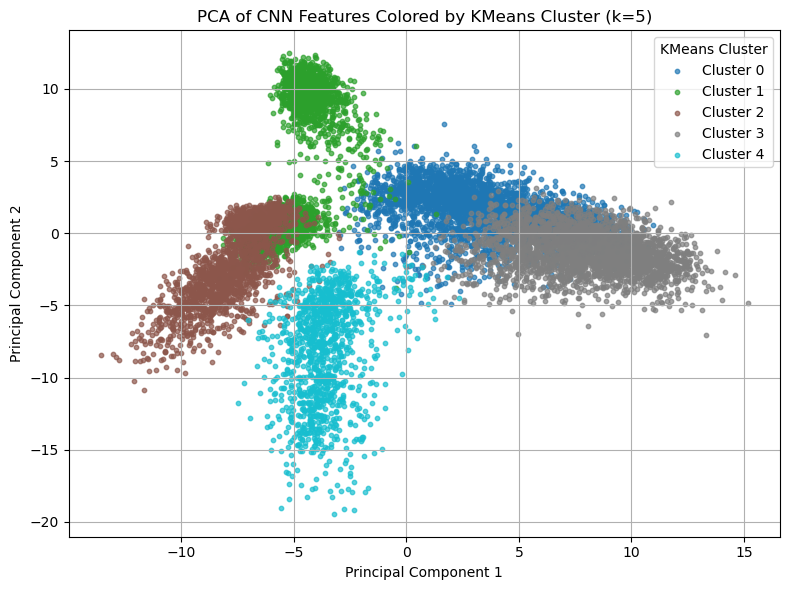

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Step 1: Prepare feature matrix and labels
X = features_df.drop(columns=["label"]).values

# Step 2: Run KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Step 3: Reduce to 2D with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 4: Plot with discrete legend
unique_clusters = np.unique(cluster_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

plt.figure(figsize=(8, 6))
for i, cluster in enumerate(unique_clusters):
    idx = cluster_labels == cluster
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[i], label=f"Cluster {cluster}", alpha=0.7, s=10)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of CNN Features Colored by KMeans Cluster (k=5)")
plt.legend(title="KMeans Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


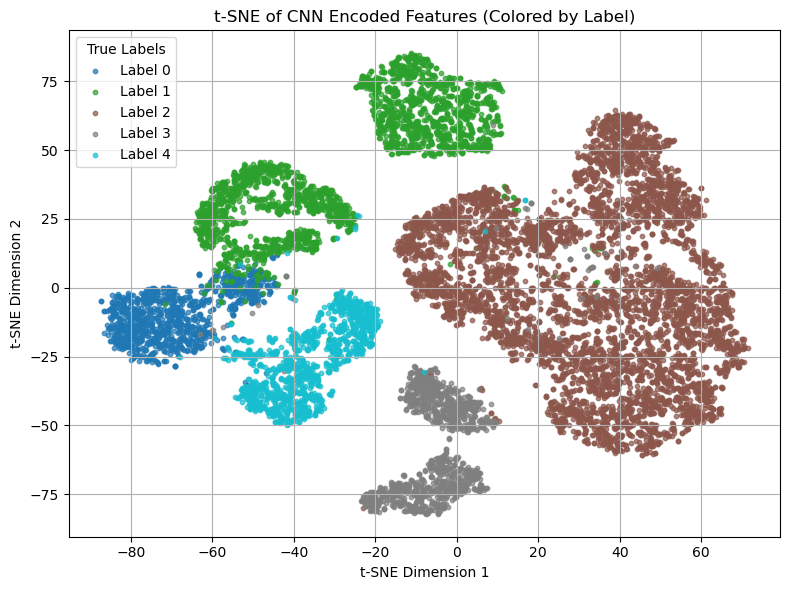

In [39]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
import numpy as np

# Get feature vectors (X) and labels (y)
X = features_df.drop(columns=["label"]).values
y = features_df["label"].values

# Run t-SNE to reduce 512-dim to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X)

# Set up a colormap and discrete label names
unique_labels = np.unique(y)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Plot points by label
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    indices = y == label
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], 
                color=colors[i], label=f"Label {label}", alpha=0.7, s=10)

plt.title("t-SNE of CNN Encoded Features (Colored by Label)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="True Labels", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


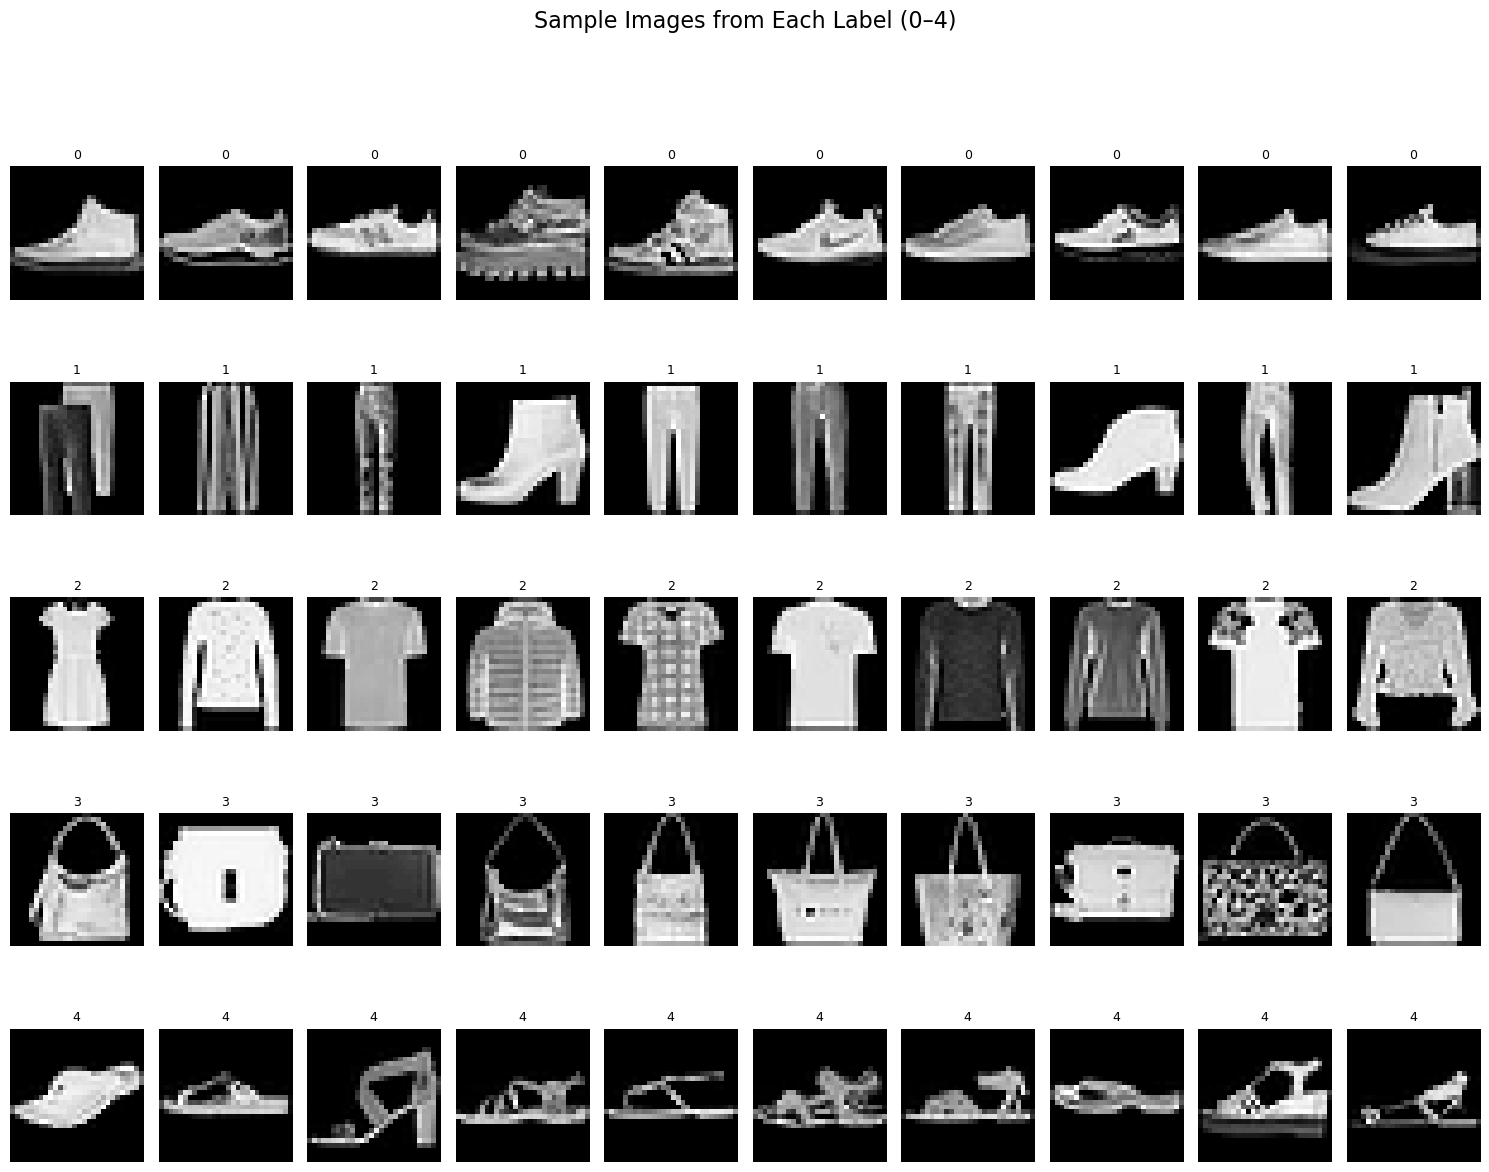

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def show_label_samples(images_tensor, label_tensor, n_labels=5, samples_per_label=10):
    """
    Display sample images from each label group (0 to n_labels-1),
    with label annotations below each image.
    """
    images_np = images_tensor.squeeze().cpu().numpy()  # shape: (N, 28, 28)
    labels_np = label_tensor.cpu().numpy()             # shape: (N,)

    plt.figure(figsize=(samples_per_label * 1.5, n_labels * 2.5))

    for label in range(n_labels):
        indices = np.where(labels_np == label)[0]
        if len(indices) == 0:
            continue
        selected = np.random.choice(indices, size=min(samples_per_label, len(indices)), replace=False)

        for i, idx in enumerate(selected):
            plt_idx = label * samples_per_label + i + 1
            plt.subplot(n_labels, samples_per_label, plt_idx)
            plt.imshow(images_np[idx], cmap='gray')
            plt.axis('off')
            plt.title(f"{labels_np[idx]}", fontsize=9)

            if i == 0:
                plt.ylabel(f"Label {label}", fontsize=12)

    plt.suptitle("Sample Images from Each Label (0–4)", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

# Example usage:
show_label_samples(x_test_tensor, y_test_tensor, n_labels=5, samples_per_label=10)